In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import copy
import networkx as nx
import random
from random import sample

#### Load data

In [2]:
FlightsNx = pd.read_pickle("FlightsNx.pkl")

#### Implement as network. 


In [3]:
Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)
print(nx.info(Network))

Name: 
Type: Graph
Number of nodes: 310
Number of edges: 2868
Average degree:  18.5032


In [4]:
degree_dict = nx.algorithms.centrality.degree_centrality(Network) 
degree_values = list(degree_dict.values())
# Create dataframe
degrees = pd.DataFrame(degree_values)
degrees.columns = ["degree"]
degrees["degree_unnormalized"] = degrees["degree"]*(len(Network.nodes)-1)
degrees["airport"] = degree_dict.keys()

## Attacks and Errors
### Analysis of how removing certain airports affect network characteristics

#### Measures for entire network

In [5]:
print(nx.info(Network))
print("The average shortest path is: {}".format(nx.average_shortest_path_length(Network)))
print("The average clustering coefficient is: {}".format(nx.average_clustering(Network)))
print("The diameter of the network is: {}".format(nx.diameter(Network)))
print("The global efficiency of the network is: {}".format(nx.global_efficiency(Network)))

Name: 
Type: Graph
Number of nodes: 310
Number of edges: 2868
Average degree:  18.5032
The average shortest path is: 2.3133312454327175
The average clustering coefficient is: 0.6329597748621263
The diameter of the network is: 5
The global efficiency of the network is: 0.46953265824570517


In [6]:
# What happens to network characteristics as the most important airports are removed? 
degrees.sort_values(by = "degree_unnormalized", inplace = True, ascending = False)
average_clustering = list()
average_shortest_path_length = list()
global_efficiency = list()
average_degree = list()
for i in range(30):
    net = Network.subgraph(nodes = list(degrees["airport"])[i:])
    average_clustering.append(nx.average_clustering(net))
    
    #average_shortest_path_length.append(nx.average_shortest_path_length(net))
    
    global_efficiency.append(nx.global_efficiency(net))
    
    average_degree.append(sum(dict(net.degree()).values())/len(dict(net.degree()).values()))
    if i%5 == 0:
        print(i)
    
measures_attacks = pd.DataFrame({"average_degree":average_degree,
                                "average_clustering":average_clustering,
                                "global_efficiency":global_efficiency})
#measures_attacks.head()

0
5
10
15
20
25


In [7]:
measures_attacks.to_pickle("measures_attacks.pkl")

In [27]:
## What happens to network characteristics if nodes are randomly removed? 
random.seed(a = 12345)
degrees.sort_values(by = "degree_unnormalized", inplace = True, ascending = False)
average_clustering = list()
#average_shortest_path_length = list()
#global_efficiency = list()
average_degree = list()
for i in range(30):
    net = Network.subgraph(nodes = sample(list(degrees["airport"]), len(list(degrees["airport"]))-1))
    average_clustering.append(nx.average_clustering(net))
    
    #average_shortest_path_length.append(nx.average_shortest_path_length(net))
    
    #global_efficiency.append(nx.global_efficiency(net))
    
    average_degree.append(sum(dict(net.degree()).values())/len(dict(net.degree()).values()))
    if i%5 == 0:
        print(i)
    
measures_random = pd.DataFrame({"average_degree":average_degree,
                                "average_clustering":average_clustering})
measures_random.head()

0
5
10
15
20
25


,average_degree,average_clustering
0,18.368932,0.636063
1,18.556634,0.635022
2,17.818770,0.624661
3,18.556634,0.635019
4,18.446602,0.632877


In [28]:
measures_random.to_pickle("measures_random.pkl")

In [8]:
# What happens to network characteristics as the least important nodes are removed?
degrees.sort_values(by = "degree_unnormalized", inplace = True, ascending = False)
average_clustering = list()
average_shortest_path_length = list()
global_efficiency = list()
average_degree = list()
for i in range(30):
    net = Network.subgraph(nodes = list(degrees["airport"])[:len(degrees["airport"])-i])
    average_clustering.append(nx.average_clustering(net))
    
    #average_shortest_path_length.append(nx.average_shortest_path_length(net))
    
    global_efficiency.append(nx.global_efficiency(net))
    
    average_degree.append(sum(dict(net.degree()).values())/len(dict(net.degree()).values()))
    if i%5 == 0:
        print(i)
    
measures_errors = pd.DataFrame({"average_degree":average_degree,
                                "average_clustering":average_clustering,
                                "global_efficiency":global_efficiency})
measures_errors.head()

0
5
10
15
20
25


,average_degree,average_clustering,global_efficiency
0,18.503226,0.632960,0.469533
1,18.556634,0.635013,0.469762
2,18.610390,0.637079,0.469995
3,18.664495,0.639165,0.470416
4,18.718954,0.641258,0.470655


In [9]:
measures_errors.to_pickle("measures_errors.pkl")

#### Mapping airport network geographically

In [29]:
attack_effect = pd.read_pickle("measures_attacks.pkl")
error_effect = pd.read_pickle("measures_errors.pkl")
random_effect = pd.read_pickle("measures_random.pkl")
plist = list(range(1,31))
plist = [(x-1) * 1/310 for x in plist]

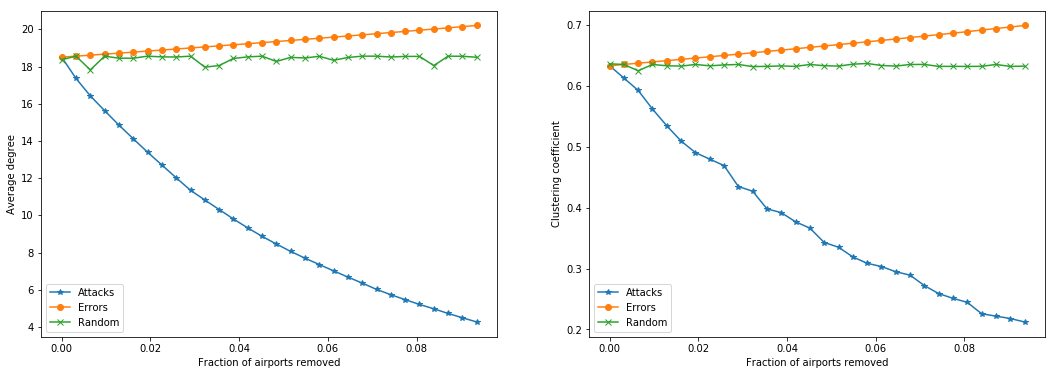

In [30]:
fig, ax = plt.subplots(figsize = (18,6))
plt.subplot(1,2,1)
plt.plot(plist, attack_effect["average_degree"], label = "Attacks", marker = "*")
plt.plot(plist, error_effect["average_degree"], label = "Errors", marker = "o")
plt.plot(plist, random_effect["average_degree"], label = "Random", marker = "x")
#plt.title("Effect of attacks and errors on network average degree")
plt.legend(loc = "lower left")
plt.xlabel("Fraction of airports removed")
plt.ylabel("Average degree")

plt.subplot(1,2,2)
plt.plot(plist, attack_effect["average_clustering"], label = "Attacks", marker = "*")
plt.plot(plist, error_effect["average_clustering"], label = "Errors", marker = "o")
plt.plot(plist, random_effect["average_clustering"], label = "Random", marker = "x")
#plt.title("Effect of attacks and errors on network clustering coefficient")
plt.legend(loc = "lower left")
plt.xlabel("Fraction of airports removed")
plt.ylabel("Clustering coefficient")
plt.savefig(fname = "Figures/attacksanderrors.png", format = "png", bbox_inches = "tight")

plt.show()